In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay
)

# Load Data

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Exploratory Data Analysis


## Overview


In [3]:
# Overview of the dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
dtypes: int64(7), object(9)
memory usage: 5.5+ MB


In [4]:
# Display the first few rows
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [5]:
# Numerical features
X.describe()

,age,balance,day_of_week,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [6]:
# Categorical features
X.describe(include=['object', 'category'])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,44923,45211,43354,45211,45211,45211,32191,45211,8252
unique,11,3,3,2,2,2,2,12,3
top,blue-collar,married,secondary,no,yes,no,cellular,may,failure
freq,9732,27214,23202,44396,25130,37967,29285,13766,4901


## Target Variable

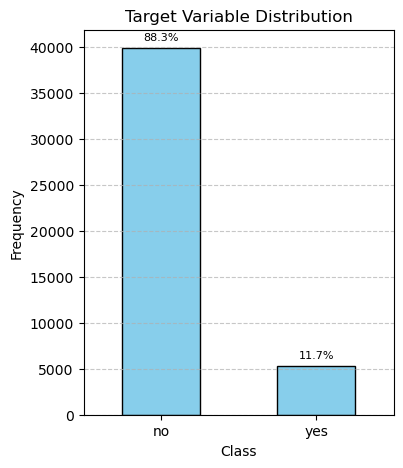

In [7]:
# Calculate value counts and percentage distribution
class_counts = y['y'].value_counts()
class_distribution = class_counts / class_counts.sum() * 100

# Create a bar plot
plt.figure(figsize=(4, 5))
ax = class_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add percentage labels on top of bars
for i, v in enumerate(class_counts):
    percentage = class_distribution.iloc[i]
    ax.text(i, v + 0.02 * max(class_counts), f'{percentage:.1f}%',
            ha='center', fontsize=8, color='black')

# Formatting the plot
plt.title('Target Variable Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep class labels readable
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Numerical Features

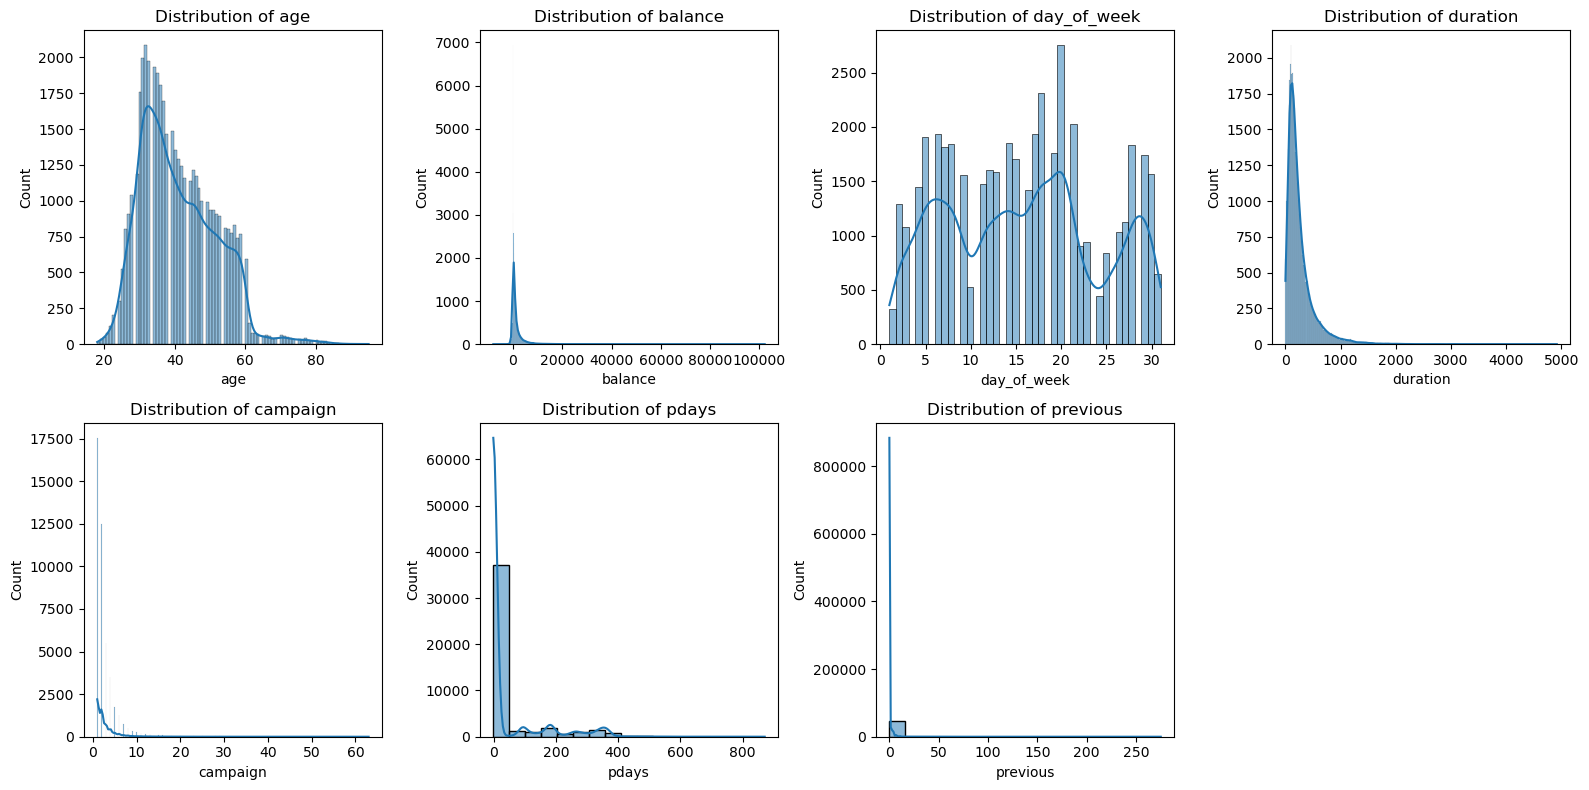

In [8]:
# Select numerical columns
numerical_cols = X.select_dtypes(include=['int64']).columns

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Plot each numerical column
for i, col in enumerate(numerical_cols):
    sns.histplot(X[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

# Hide the empty subplot if fewer than 8 plots
for j in range(i + 1, 8):
    fig.delaxes(axes[j])

# Show the plot
plt.tight_layout()
plt.show()

## Categorical Features

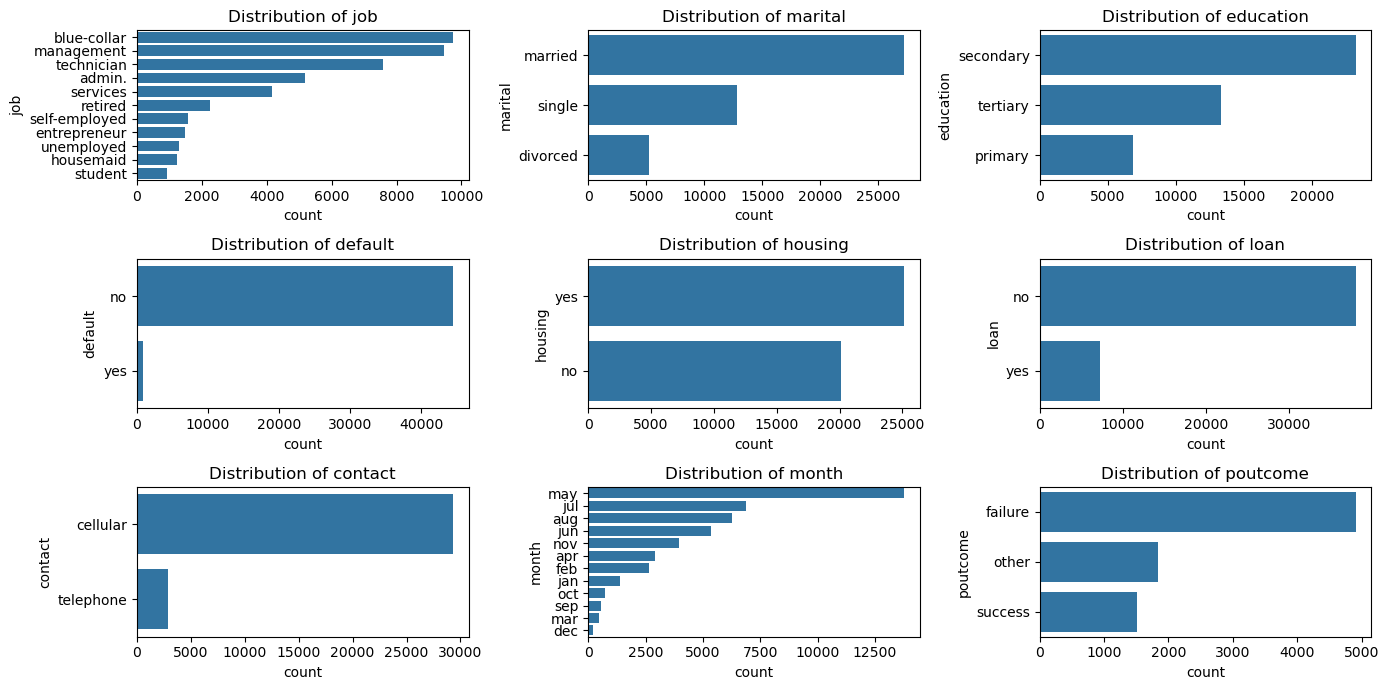

In [9]:
# Select categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Create a 2x4 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(14, 7))
axes = axes.flatten()

# Plot each categorical column
for i, col in enumerate(categorical_cols):
    sns.countplot(X[col], ax=axes[i], order=X[col].value_counts().index)
    axes[i].set_title(f'Distribution of {col}')

# Show the plot
plt.tight_layout()
plt.show()

# Data Cleaning


## Handle Missing Values


<Axes: >

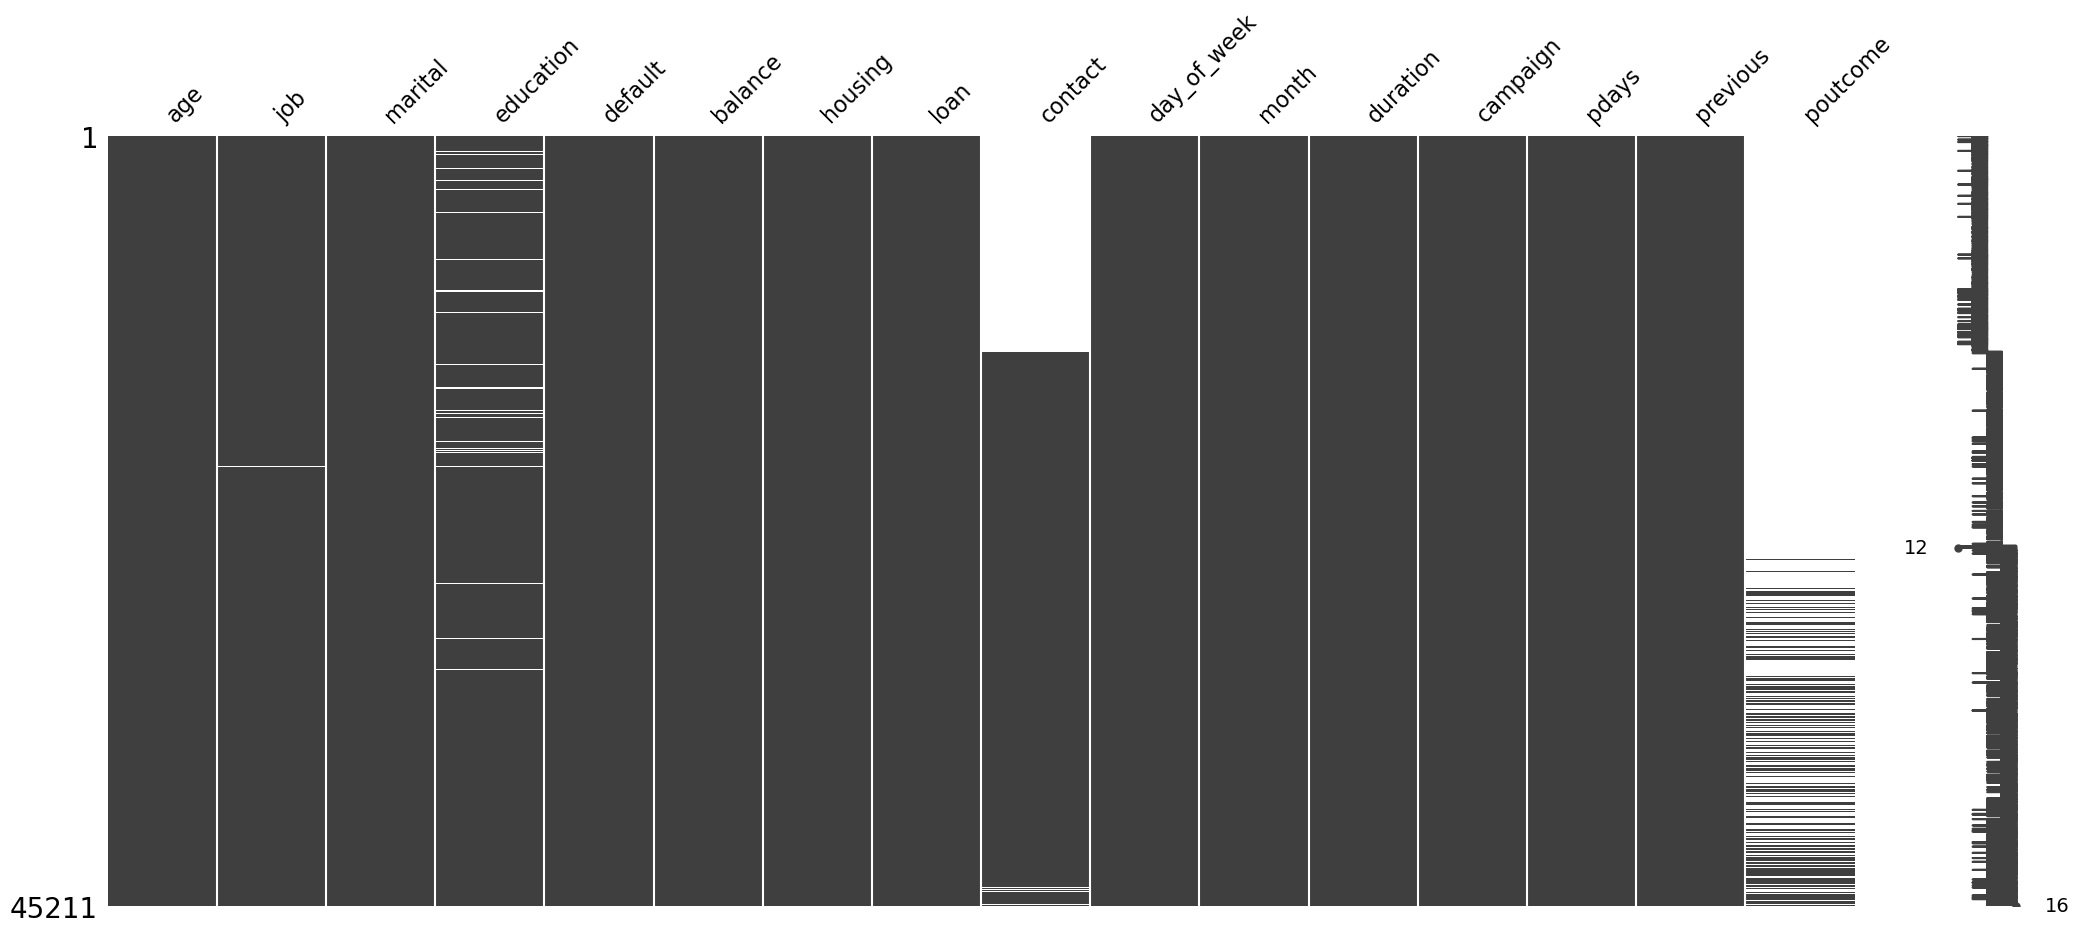

In [10]:
# Visualize missing values
msno.matrix(X)

In [11]:
# Exact number of missing values
X.isnull().sum()

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

The dataset contains missing values in four features: `job`, `education`, `contact`, and `poutcome`. Here are the techniques that will be used to handle the missing values:
1) Due to the high proportion of missing values in `contact` and `poutcome`, these features will be dropped to maintain data integrity.
2) In contrast, `job` and `education` have missing values in less than 10% of the dataset, making them suitable for imputation.
3) The **k-Nearest Neighbors Imputer (kNNImputer)** from **scikit-learn** will be used to fill in the missing values for `education` and `job` based on similar observations.
4) Since **kNNImputer** requires numerical inputs, categorical features will be converted into their numerical representations as follows:
    * `education` and `job` will be encoded using **LabelEncoder** since the the imputation will only be carried out for these features.
    * `marital`, and `month` will be encoded using **OneHotEncoding** since there are no ordinal relationships within the data.
    * `default`, `housing`, and `loan` will simply be encoded into their binary representations (i.e. yes-1, no-0)

In [12]:
# Create a copy of X for cleaning
X_clean = X.copy()

In [13]:
# Drop `contact` and `poutcome`
X_clean.drop(['contact','poutcome'],axis=1,inplace=True)
X_clean.head()

,age,job,marital,education,default,balance,housing,loan,day_of_week,month,duration,campaign,pdays,previous
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,5,may,92,1,-1,0
4,33,NaN,single,NaN,no,1,no,no,5,may,198,1,-1,0


In [14]:
# Initialize LabelEncoders - one for each feature to store mapping
le_education = LabelEncoder()
le_job = LabelEncoder()

# Converting non-numeric features to numeric (NaN values will remain NaN)
X_clean['education_transform'] = le_education.fit_transform(X_clean['education'].astype(str))
X_clean['job_transform'] = le_job.fit_transform(X_clean['job'].astype(str))

# Change NaN labels back into np.nan
X_clean['education_transform'] = X_clean['education_transform'].replace(0,np.nan)
X_clean['job_transform'] = X_clean['job_transform'].replace(5,np.nan)

# Display the encoded values
X_clean[['education', 'education_transform', 'job', 'job_transform']].head()

,education,education_transform,job,job_transform
0,tertiary,3.0,management,4.0
1,secondary,2.0,technician,10.0
2,secondary,2.0,entrepreneur,2.0
3,NaN,NaN,blue-collar,1.0
4,NaN,NaN,NaN,NaN


In [15]:
# One-Hot Encoding
X_clean = pd.get_dummies(X_clean, columns=['marital','month'], drop_first=False, dtype=float)
X_clean.columns

Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'education_transform', 'job_transform', 'marital_divorced',
       'marital_married', 'marital_single', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep'],
      dtype='object')

In [16]:
# Transform binary features
X_clean['default_transform'] = X_clean['default'].map({'yes': 1, 'no': 0})
X_clean['housing_transform'] = X_clean['housing'].map({'yes': 1, 'no': 0})
X_clean['loan_transform'] = X_clean['loan'].map({'yes': 1, 'no': 0})

# Display the binary transformation
X_clean[['default','default_transform','housing','housing_transform','loan','loan_transform']].head()

,default,default_transform,housing,housing_transform,loan,loan_transform
0,no,0,yes,1,no,0
1,no,0,yes,1,no,0
2,no,0,yes,1,yes,1
3,no,0,yes,1,no,0
4,no,0,no,0,no,0


Now that all features have been successfully converted into numerical representations—either through **Label Encoding**, **One-Hot Encoding**, or by transforming boolean values into binary format—we can proceed with the imputation process. Begin by scaling the data to ensure that all feature contribute equally to the imputation process.

In [17]:
# Select features that could be relevant to job for imputation
features_for_imputation = [
    'age',
    'balance',
    'day_of_week',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'education_transform',
    'job_transform',
    'marital_divorced',
    'marital_married',
    'marital_single',
    'month_jan',
    'month_feb',
    'month_mar',
    'month_apr',
    'month_jun',
    'month_jul',
    'month_aug',
    'month_sep',
    'month_oct',
    'month_nov',
    'month_dec',
    'default_transform',
    'housing_transform',
    'loan_transform'
]

# Dataframe with selected features
X_clean_subset = X_clean[features_for_imputation]

# Scale the data
scaler = MinMaxScaler()
X_clean_subset_scaled = pd.DataFrame(scaler.fit_transform(X_clean_subset), columns=X_clean_subset.columns)

# Display scaled data subset
X_clean_subset_scaled

,age,balance,day_of_week,duration,campaign,pdays,previous,education_transform,job_transform,marital_divorced,...,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec,default_transform,housing_transform,loan_transform
0,0.519481,0.092259,0.133333,0.053070,0.000000,0.000000,0.000000,1.0,0.363636,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.337662,0.073067,0.133333,0.030704,0.000000,0.000000,0.000000,0.5,0.909091,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.194805,0.072822,0.133333,0.015453,0.000000,0.000000,0.000000,0.5,0.181818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.376623,0.086476,0.133333,0.018707,0.000000,0.000000,0.000000,NaN,0.090909,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.194805,0.072812,0.133333,0.040260,0.000000,0.000000,0.000000,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,0.428571,0.080293,0.533333,0.198658,0.032258,0.000000,0.000000,1.0,0.909091,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45207,0.688312,0.088501,0.533333,0.092721,0.016129,0.000000,0.000000,0.0,0.545455,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45208,0.701299,0.124689,0.533333,0.229158,0.064516,0.212156,0.010909,0.5,0.545455,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45209,0.506494,0.078868,0.533333,0.103294,0.048387,0.000000,0.000000,0.5,0.090909,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Next, proceed with the `KNNImputer`. Compare missing values from before and after imputation.

Before:

In [18]:
# Before imputation
X[['job','education']].head()

,job,education
0,management,tertiary
1,technician,secondary
2,entrepreneur,secondary
3,blue-collar,NaN
4,NaN,NaN


After:

In [ ]:
# Initialize KNNImputer (use n_neighbors=1 since taking an average between multiple neighbors makes no sense in this case)
imputer = KNNImputer(n_neighbors=1, missing_values=np.nan)

# Perform KNN Imputation (fit and transform the data)
X_imputed = imputer.fit_transform(X_clean_subset_scaled)

# Inverse transform for scaler to get original label encoding
X_imputed = scaler.inverse_transform(X_imputed)

# Convert imputed data back into a DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=features_for_imputation)

# Round the imputed job values to the nearest integer (as job is categorical)
X_imputed['education_transform'] = np.round(X_imputed['education_transform']).astype(int)
X_imputed['job_transform'] = np.round(X_imputed['job_transform']).astype(int)

# Inverse transform the LabelEncoder values
imputed_job = le_job.inverse_transform(X_imputed['job_transform'].head())
imputed_education = le_education.inverse_transform(X_imputed['education_transform'].head())

# Format into dataframe
imputed_after = pd.DataFrame({'job_transform': imputed_job, 'education_transform': imputed_education})

# Display values after imputation
imputed_after

,job_transform,education_transform
0,management,tertiary
1,technician,secondary
2,entrepreneur,secondary
3,blue-collar,primary
4,admin.,tertiary


Final check for missing values:

In [20]:
# Missing values
X_imputed.isnull().sum()

age                    0
balance                0
day_of_week            0
duration               0
campaign               0
pdays                  0
previous               0
education_transform    0
job_transform          0
marital_divorced       0
marital_married        0
marital_single         0
month_jan              0
month_feb              0
month_mar              0
month_apr              0
month_jun              0
month_jul              0
month_aug              0
month_sep              0
month_oct              0
month_nov              0
month_dec              0
default_transform      0
housing_transform      0
loan_transform         0
dtype: int64

There are no more missing values.

# Feature Engineering

## Handle imbalanced target variable



In [21]:
# Convert target y into binary integers
y_clean = y.copy()
y_clean['y_integer'] = y_clean['y'].map({'yes': 1, 'no': 0})
y_clean['y_integer'].value_counts(normalize=True)

y_integer
0    0.883015
1    0.116985
Name: proportion, dtype: float64

The target variable y is highly imbalanced with only an 11% success rate. This imbalance between the number of success and failure can significantly impact the eventual model. Therefore, apply SMOTE to have a more balanced target class distribution.

In [22]:
# SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed, y_clean['y_integer'])

# Display class redistribution after resampling
print(f"Class distribution after resampling: {np.bincount(y_resampled)}")

Class distribution after resampling: [39922 39922]


Now that the class distribution is equal, the model will be able to perform better during training and testing.

## Scaling

In [23]:
# Drop `duration` since it is only known after a call has concluded - which by then the outcome is also known
X_resampled.drop('duration', axis=1, inplace=True)

In [24]:
# Scale data
X_resampled_scaled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)
X_resampled_scaled

,age,balance,day_of_week,campaign,pdays,previous,education_transform,job_transform,marital_divorced,marital_married,...,month_jun,month_jul,month_aug,month_sep,month_oct,month_nov,month_dec,default_transform,housing_transform,loan_transform
0,0.519481,0.092259,0.133333,0.000000,0.00000,0.000000,1.0,0.363636,0.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0
1,0.337662,0.073067,0.133333,0.000000,0.00000,0.000000,0.5,0.909091,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0
2,0.194805,0.072822,0.133333,0.000000,0.00000,0.000000,0.5,0.181818,0.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,1.0
3,0.376623,0.086476,0.133333,0.000000,0.00000,0.000000,0.0,0.090909,0.000000,1.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0
4,0.194805,0.072812,0.133333,0.000000,0.00000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79839,0.150519,0.087164,0.249000,0.025645,0.31188,0.008764,0.5,0.454545,0.000000,1.000000,...,0.000000,0.000000,0.0,0.470012,0.0,0.0,0.0,0.0,0.529988,0.0
79840,0.203525,0.073536,0.522380,0.000000,0.00000,0.000000,0.5,0.181818,0.000000,0.451258,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.548742,0.0
79841,0.213443,0.073786,0.787821,0.107398,0.00000,0.000000,0.0,0.181818,0.000000,0.776443,...,0.223557,0.776443,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0
79842,0.233698,0.076897,0.332102,0.016044,0.00000,0.000000,0.5,0.090909,0.502638,0.000000,...,0.502638,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0


# Model Building

## Split the data into training and testing sets


In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (63875, 25)
X_test shape: (15969, 25)
y_train shape: (63875,)
y_test shape: (15969,)


## Train and evaluate models

### Logistic Regression


In [26]:
# Initialize Logistic Regression model
log_reg = LogisticRegression(random_state=42, class_weight='balanced',max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_log_reg = log_reg.predict(X_train)
y_test_pred_log_reg = log_reg.predict(X_test)

# Evaluation metrics for Logistic Regression (Train)
train_log_reg_accuracy = round(accuracy_score(y_train, y_train_pred_log_reg), 4)
train_log_reg_precision = round(precision_score(y_train, y_train_pred_log_reg), 4)
train_log_reg_recall = round(recall_score(y_train, y_train_pred_log_reg), 4)
train_log_reg_f1_score = round(f1_score(y_train, y_train_pred_log_reg), 4)
train_log_reg_roc_auc = round(roc_auc_score(y_train, y_train_pred_log_reg), 4)

# Evaluation metrics for Logistic Regression (Test)
test_log_reg_accuracy = round(accuracy_score(y_test, y_test_pred_log_reg), 4)
test_log_reg_precision = round(precision_score(y_test, y_test_pred_log_reg), 4)
test_log_reg_recall = round(recall_score(y_test, y_test_pred_log_reg), 4)
test_log_reg_f1_score = round(f1_score(y_test, y_test_pred_log_reg), 4)
test_log_reg_roc_auc = round(roc_auc_score(y_test, y_test_pred_log_reg), 4)

# Display evaluation metrics for Logistic Regression
log_reg_results = pd.DataFrame({
    'Model (Dataset)': ['Logistic Regression (Train)', 'Logistic Regression (Test)'],
    'Accuracy': [train_log_reg_accuracy, test_log_reg_accuracy],
    'Precision': [train_log_reg_precision, test_log_reg_precision],
    'Recall': [train_log_reg_recall, test_log_reg_recall],
    'F1 Score': [train_log_reg_f1_score, test_log_reg_f1_score],
    'ROC AUC': [train_log_reg_roc_auc, test_log_reg_roc_auc]
})

# Display results
log_reg_results

,Model (Dataset),Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression (Train),0.6824,0.6947,0.6479,0.6705,0.6823
1,Logistic Regression (Test),0.6810,0.6984,0.6478,0.6722,0.6813


### Random Forest Classifier


In [27]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
rf.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# Evaluation metrics for Random Forest (Train)
train_rf_accuracy = round(accuracy_score(y_train, y_train_pred_rf), 4)
train_rf_precision = round(precision_score(y_train, y_train_pred_rf), 4)
train_rf_recall = round(recall_score(y_train, y_train_pred_rf), 4)
train_rf_f1_score = round(f1_score(y_train, y_train_pred_rf), 4)
train_rf_roc_auc = round(roc_auc_score(y_train, y_train_pred_rf), 4)

# Evaluation metrics for Random Forest (Test)
test_rf_accuracy = round(accuracy_score(y_test, y_test_pred_rf), 4)
test_rf_precision = round(precision_score(y_test, y_test_pred_rf), 4)
test_rf_recall = round(recall_score(y_test, y_test_pred_rf), 4)
test_rf_f1_score = round(f1_score(y_test, y_test_pred_rf), 4)
test_rf_roc_auc = round(roc_auc_score(y_test, y_test_pred_rf), 4)

# Display evaluation metrics for Random Forest
rf_results = pd.DataFrame({
    'Model (Dataset)': ['Random Forest (Train)', 'Random Forest (Test)'],
    'Accuracy': [train_rf_accuracy, test_rf_accuracy],
    'Precision': [train_rf_precision, test_rf_precision],
    'Recall': [train_rf_recall, test_rf_recall],
    'F1 Score': [train_rf_f1_score, test_rf_f1_score],
    'ROC AUC': [train_rf_roc_auc, test_rf_roc_auc]
})

# Display results
rf_results

,Model (Dataset),Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Random Forest (Train),1.0000,1.0000,0.9999,1.0000,1.0000
1,Random Forest (Test),0.9305,0.9638,0.8959,0.9286,0.9308


### XGBoost Classifier


In [28]:
# Initialize XGBoost Classifier
xgb = XGBClassifier(random_state=42, eval_metric='logloss')

# Train the model
xgb.fit(X_train, y_train)

# Predict on train and test data
y_train_pred_xgb = xgb.predict(X_train)
y_test_pred_xgb = xgb.predict(X_test)

# Evaluation metrics for XGBoost (Train)
train_xgb_accuracy = round(accuracy_score(y_train, y_train_pred_xgb), 4)
train_xgb_precision = round(precision_score(y_train, y_train_pred_xgb), 4)
train_xgb_recall = round(recall_score(y_train, y_train_pred_xgb), 4)
train_xgb_f1_score = round(f1_score(y_train, y_train_pred_xgb), 4)
train_xgb_roc_auc = round(roc_auc_score(y_train, y_train_pred_xgb), 4)

# Evaluation metrics for XGBoost (Test)
test_xgb_accuracy = round(accuracy_score(y_test, y_test_pred_xgb), 4)
test_xgb_precision = round(precision_score(y_test, y_test_pred_xgb), 4)
test_xgb_recall = round(recall_score(y_test, y_test_pred_xgb), 4)
test_xgb_f1_score = round(f1_score(y_test, y_test_pred_xgb), 4)
test_xgb_roc_auc = round(roc_auc_score(y_test, y_test_pred_xgb), 4)

# Display evaluation metrics for XGBoost
xgb_results = pd.DataFrame({
    'Model (Dataset)': ['XGBoost (Train)', 'XGBoost (Test)'],
    'Accuracy': [train_xgb_accuracy, test_xgb_accuracy],
    'Precision': [train_xgb_precision, test_xgb_precision],
    'Recall': [train_xgb_recall, test_xgb_recall],
    'F1 Score': [train_xgb_f1_score, test_xgb_f1_score],
    'ROC AUC': [train_xgb_roc_auc, test_xgb_roc_auc]
})

# Display results
xgb_results

,Model (Dataset),Accuracy,Precision,Recall,F1 Score,ROC AUC
0,XGBoost (Train),0.9525,0.9890,0.9149,0.9505,0.9524
1,XGBoost (Test),0.9324,0.9707,0.8931,0.9303,0.9328


## Comparison

In [29]:
# Compare the different models
pd.concat([log_reg_results, rf_results, xgb_results]).reset_index(drop=True)

,Model (Dataset),Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression (Train),0.6824,0.6947,0.6479,0.6705,0.6823
1,Logistic Regression (Test),0.6810,0.6984,0.6478,0.6722,0.6813
2,Random Forest (Train),1.0000,1.0000,0.9999,1.0000,1.0000
3,Random Forest (Test),0.9305,0.9638,0.8959,0.9286,0.9308
4,XGBoost (Train),0.9525,0.9890,0.9149,0.9505,0.9524
5,XGBoost (Test),0.9324,0.9707,0.8931,0.9303,0.9328


Both Random Forest and XGBoost demonstrated high and comparable performance, each achieving approximately 93% test accuracy. In contrast, the Logistic Regression model performed significantly lower, with an accuracy of 68%.

It can be seen that while Random Forest yields better training scores, XGBoost performs slightly better on testing scores, indicating that XGBoost is better at generalizing the data while the Random Forest model is overfitting.

To determine the superior model, a more rigorous evaluation through cross-validation will be conducted.

# Cross Validation


In [30]:
# Cross validation
xgb_cv_scores = cross_validate(xgb, X_train, y_train, cv=10, scoring=['accuracy','precision','recall', 'f1', 'roc_auc'])
rf_cv_scores = cross_validate(rf, X_train, y_train, cv=10, scoring=['accuracy','precision','recall', 'f1', 'roc_auc'])

# Store results
rf_cv_results = pd.DataFrame({
    'name': ['Random Forest'],
    'mean_accuracy': [round(rf_cv_scores['test_accuracy'].mean(), 4)],
    'mean_precision': [round(rf_cv_scores['test_precision'].mean(), 4)],
    'mean_recall': [round(rf_cv_scores['test_recall'].mean(), 4)],
    'mean_f1_score': [round(rf_cv_scores['test_f1'].mean(), 4)],
    'mean_roc_auc': [round(rf_cv_scores['test_roc_auc'].mean(), 4)]
})

xgb_cv_results = pd.DataFrame({
    'name': ['XGBoost'],
    'mean_accuracy': [round(xgb_cv_scores['test_accuracy'].mean(), 4)],
    'mean_precision': [round(xgb_cv_scores['test_precision'].mean(), 4)],
    'mean_recall': [round(xgb_cv_scores['test_recall'].mean(), 4)],
    'mean_f1_score': [round(xgb_cv_scores['test_f1'].mean(), 4)],
    'mean_roc_auc': [round(xgb_cv_scores['test_roc_auc'].mean(), 4)]
})

# Display results
pd.concat([rf_cv_results, xgb_cv_results])


,name,mean_accuracy,mean_precision,mean_recall,mean_f1_score,mean_roc_auc
0,Random Forest,0.9337,0.9663,0.8985,0.9312,0.9715
0,XGBoost,0.9342,0.9693,0.8965,0.9314,0.9703


Even with cross validation, the two models persist to yield similar results in terms of their performance for their training results.

In order to move forward, heuristics and intuition will be applied to choose between the two models. XGBoost is generally preferred over Random Forest due to a number of factors including compute time, ease of tuning, handling of categorical variables, and most importantly in this case, its effectiveness in evaluating unbalanced datasets.

Furthermore, as mentioned before, the Random Forest model is likely overfitting on the training data and XGBoost is generalizing better - leading to a better performance on the testing data as seen previously.

Therefore, XGBoost will be used moving forward.

# Hyperparameter Tuning

In [31]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Shrinkage rate
    'max_depth': [3, 5, 7, 10],                 # Maximum tree depth
    'subsample': [0.6, 0.8, 1.0],               # Fraction of samples used for training
    'colsample_bytree': [0.6, 0.8, 1.0],        # Fraction of features for each tree
    'gamma': [0, 1, 5],                         # Minimum loss reduction for split
    'reg_alpha': [0, 0.1, 1],                   # L1 regularization
    'reg_lambda': [1, 2, 5],                    # L2 regularization
}

xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'),
    param_distributions=param_grid,
    n_iter=50,            # Number of parameter settings sampled
    scoring='f1_macro',   # Evaluation metric
    cv=5,                 # 5-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1             # Use all available cores
)

# Fit to training data
xgb_random_search.fit(X_train, y_train)

# Display best parameters
print(f"Best Parameters: {xgb_random_search.best_params_}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


# Final Evaluation

In [37]:
# Retrieve the best model
best_xgb = xgb_random_search.best_estimator_

# Predict on train and test data
y_train_pred_best_xgb = best_xgb.predict(X_train)
y_test_pred_best_xgb = best_xgb.predict(X_test)

# Evaluation metrics for Best XGBoost (Train)
train_best_xgb_accuracy = round(accuracy_score(y_train, y_train_pred_best_xgb), 4)
train_best_xgb_precision = round(precision_score(y_train, y_train_pred_best_xgb), 4)
train_best_xgb_recall = round(recall_score(y_train, y_train_pred_best_xgb), 4)
train_best_xgb_f1_score = round(f1_score(y_train, y_train_pred_best_xgb), 4)
train_best_xgb_roc_auc = round(roc_auc_score(y_train, y_train_pred_best_xgb), 4)

# Evaluation metrics for Best XGBoost (Test)
test_best_xgb_accuracy = round(accuracy_score(y_test, y_test_pred_best_xgb), 4)
test_best_xgb_precision = round(precision_score(y_test, y_test_pred_best_xgb), 4)
test_best_xgb_recall = round(recall_score(y_test, y_test_pred_best_xgb), 4)
test_best_xgb_f1_score = round(f1_score(y_test, y_test_pred_best_xgb), 4)
test_best_xgb_roc_auc = round(roc_auc_score(y_test, y_test_pred_best_xgb), 4)

# Display evaluation metrics for Best XGBoost
best_xgb_results = pd.DataFrame({
    'Model (Dataset)': ['Best XGBoost (Train)', 'Best XGBoost (Test)'],
    'Accuracy': [train_best_xgb_accuracy, test_best_xgb_accuracy],
    'Precision': [train_best_xgb_precision, test_best_xgb_precision],
    'Recall': [train_best_xgb_recall, test_best_xgb_recall],
    'F1 Score': [train_best_xgb_f1_score, test_best_xgb_f1_score],
    'ROC AUC': [train_best_xgb_roc_auc, test_best_xgb_roc_auc]
})

# Display comparison to previous models
pd.concat([log_reg_results, rf_results, xgb_results, best_xgb_results]).reset_index(drop=True)

,Model (Dataset),Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression (Train),0.6824,0.6947,0.6479,0.6705,0.6823
1,Logistic Regression (Test),0.6810,0.6984,0.6478,0.6722,0.6813
2,Random Forest (Train),1.0000,1.0000,0.9999,1.0000,1.0000
3,Random Forest (Test),0.9305,0.9638,0.8959,0.9286,0.9308
4,XGBoost (Train),0.9525,0.9890,0.9149,0.9505,0.9524
5,XGBoost (Test),0.9324,0.9707,0.8931,0.9303,0.9328
6,Best XGBoost (Train),0.9808,0.9996,0.9618,0.9803,0.9807
7,Best XGBoost (Test),0.9342,0.9688,0.8985,0.9324,0.9345


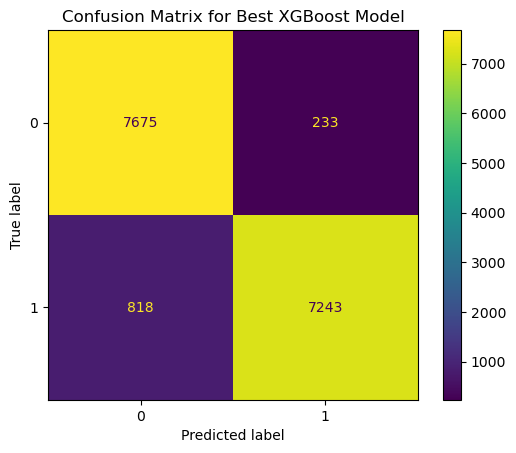

In [33]:
# Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("Confusion Matrix for Best XGBoost Model")
plt.show()

# Conclusion

The best model to predict the success of this bank marketing campaign is to use an XGBoost model with these parameters:
* subsample = 0.8
* reg_lambda = 1
* reg_alpha = 1
* n_estimators = 400
* max_depth = 10
* learning_rate = 0.1
* gamma = 0
* colsample_bytree = 0.6

This model achieved (on test set):
* accuracy = 0.9342
* precision = 0.9688
* recall = 0.8985
* f1_score = 0.9324
* roc_auc = 0.9345

Finally, it can be seen that these are the most important features to the model:

<Figure size 1000x800 with 0 Axes>

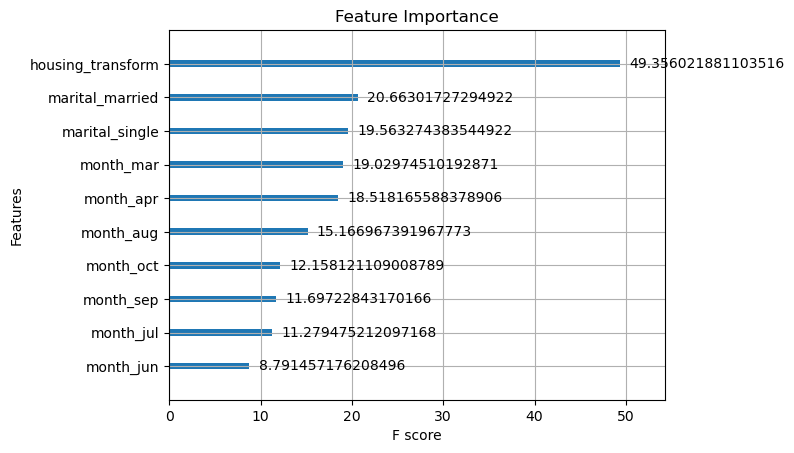

In [34]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, max_num_features=10, importance_type='gain')  # Top 10 features
plt.title('Feature Importance')
plt.show()

# Save the model

In [35]:
# Save the model
joblib.dump(best_xgb, 'best_xgboost_model.pkl')
print("Best XGBoost Model Saved!")

Best XGBoost Model Saved!
